In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score



In [175]:
# constants
FILE_PATH = "cars.csv"

## Data

This dataset was retrieved from [kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/us-sales-cars-dataset). It provides comprehensive information about used cars available for sale in the United States. The dataset contains the following key attributes:

- **Brand:** The brand or manufacturer of the car.
- **Model:** The specific model of the car.
- **Mileage:** The number of miles the car has been driven.
- **Year:** The manufacturing year of the car.
- **Status:** Indicates whether the car is new, used, or certified pre-owned.
- **Dealer:** Information about the dealer or seller offering the car.
- **Price:** The listed price of the car in USD.

In [176]:
df = pd.read_csv(FILE_PATH, encoding="utf-16")
df.head()

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,NaN,NaN,36703.0
1,Kia,Sportage,2023,New,NaN,Classic Kia,28990.0
2,Chevrolet,Camaro,2024,New,NaN,Classic Chevrolet Beaumont,41425.0
3,Ford,Bronco,2023,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0
4,Acura,TLX,2021,Used,30384.0,Mike Smith Nissan,34499.0


## Preprocessing the Data

To clean the data we will:
1. data cleaning
2. data transformation
3. feature reduction 

In [177]:
row_count = len(df)
print(f"Total Rows: {len(df)}\n")

print("Percentage of null entries:")
print(df.isnull().sum().map(lambda sum: f"{sum / row_count:.2%}"))

Total Rows: 51793

Percentage of null entries:
Brand       0.00%
Model       0.00%
Year        0.00%
Status      0.00%
Mileage    55.63%
Dealer      0.20%
Price       2.22%
dtype: object


### Missing Values
The statistics above indicate the percentage of missing data under each column. Many of the rows are missing entries for mileage.

In [178]:
print(f"Rows with missing mileage: {df.Mileage.isna().sum()}")
print(f"Rows with new status and missing mileage: {df[(df.Status == 'New') & (df.Mileage.isna())].Status.count()}")

Rows with missing mileage: 28812
Rows with new status and missing mileage: 28811


Replace the mileage to `0` of rows with new status and missing mileage then drop the rest NAs.

In [179]:
df.loc[(df['Status'] == 'New') & (df['Mileage'].isna()), 'Mileage'] = 0
df = df.dropna().reset_index(drop=True) # subset = 'Mileage' to only drop NA in column Mileage
print(f"Total Rows: {len(df)}")

Total Rows: 50540


### Remove duplicates

In [180]:
df = df.drop_duplicates().reset_index(drop=True)
print(f"Total Rows: {len(df)}")

Total Rows: 49536


### Data Transformation / Normalization
- we should scale certain features (like year to age)
- we should check for any typos or inconsistencies in text

In [181]:
df["Age"] = 2024 - df.Year

In [182]:
df.Status = df.Status.apply(lambda status: status.lower())
for status in df.Status.unique():
    print(status, end=",\t")

new,	used,	certified,	

In [183]:
df.Brand = df.Brand.apply(lambda brand: brand.lower())
for brand in df.Brand.unique():
    print(brand, end=",\t")

kia,	chevrolet,	ford,	acura,	volkswagen,	gmc,	bmw,	hyundai,	jeep,	dodge,	infiniti,	honda,	lexus,	toyota,	cadillac,	buick,	mazda,	lincoln,	mercury,	mini,	ram,	land rover,	audi,	nissan,	mercedes,	porsche,	subaru,	jaguar,	maserati,	alfa romeo,	tesla,	bentley,	genesis,	volvo,	chrysler,	mitsubishi,	fiat,	rivian,	aston martin,	lamborghini,	hummer,	saturn,	rolls-royce,	ferrari,	polestar,	lucid,	scion,	pontiac,	karma,	smart,	mclaren,	lotus,	saab,	maybach,	suzuki,	international scout,	geo,	oldsmobile,	isuzu,	

In [184]:
df.Model = df.Model.apply(lambda model: model.lower())
for model in df.Model.unique():
    print(model, end=",\t")

sportage,	camaro,	bronco,	tlx,	golf,	yukon,	m340,	sonata,	grand cherokee,	wagoneer,	durango,	mustang,	f-350,	qx30,	passport,	es,	sierra,	tundra,	ct5,	envista,	cx-5,	civic,	accord,	atlas,	4runner,	sequoia,	continental,	marquis,	is,	lx,	rz 450e,	escalade,	ls,	nautilus,	integra,	mdx,	435 i,	ilx,	palisade,	x7,	escape,	cooper,	ix m60,	x3,	canyon,	land cruiser,	lyriq,	trax,	1500,	navigator,	range rover,	rs 5,	leaf s,	altima,	e-class,	gls 600,	highlander,	gls 450,	cayenne,	q7,	tt,	wrangler,	gt,	f-150,	f-250,	defender,	qx80,	qx60,	essentia,	gle,	panamera,	m3,	telluride,	forte,	a7,	x5,	330 i,	ix xdrive50,	740,	juke,	ct6,	mazda3,	wrx,	crosstrek,	ranger,	explorer,	town car,	fusion,	2500,	gladiator,	q5,	f-pace,	discovery,	silverado,	gla,	g 550,	e-tron,	s-class,	ghibli,	tahoe,	6,	cr-v,	elantra,	gx,	odyssey,	giulia,	corvette,	c-class,	cx-9,	cl,	x4,	3,	suburban,	fiesta,	tacoma,	model x,	flying spur,	roadster,	corsair,	mx-5 miata,	xd,	tucson,	rx,	lc,	macan,	taycan,	rdx,	outback,	gv80,	g70,	challenger,

In [185]:
df.describe()

,Year,Mileage,Price,Age
count,49536.000000,49536.000000,4.953600e+04,49536.000000
mean,2020.866481,24753.097121,5.126538e+04,3.133519
std,4.275406,40373.370957,3.580619e+04,4.275406
min,1959.000000,0.000000,1.990000e+03,0.000000
25%,2020.000000,0.000000,3.079900e+04,1.000000
50%,2023.000000,0.000000,4.548000e+04,1.000000
75%,2023.000000,38564.500000,6.310500e+04,4.000000
max,2024.000000,400396.000000,1.299995e+06,65.000000


## Data Visualization

### Full Data Exploration

In [ ]:
brand_counts = df['Brand'].value_counts()
brands_to_remove = brand_counts[brand_counts < 1000].index
mask = df['Brand'].isin(brands_to_remove)

# Create a new DataFrame without rows for brands with less than 1000 rows
df_with_features = df[~mask]

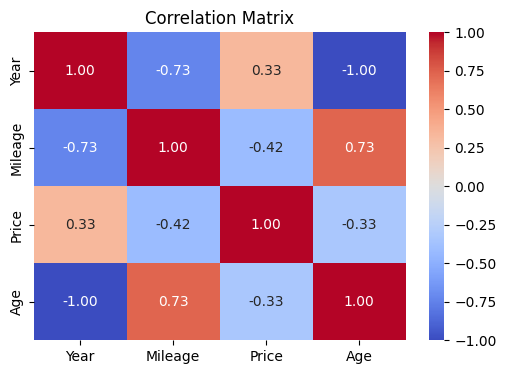

In [187]:
correlation_matrix = df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


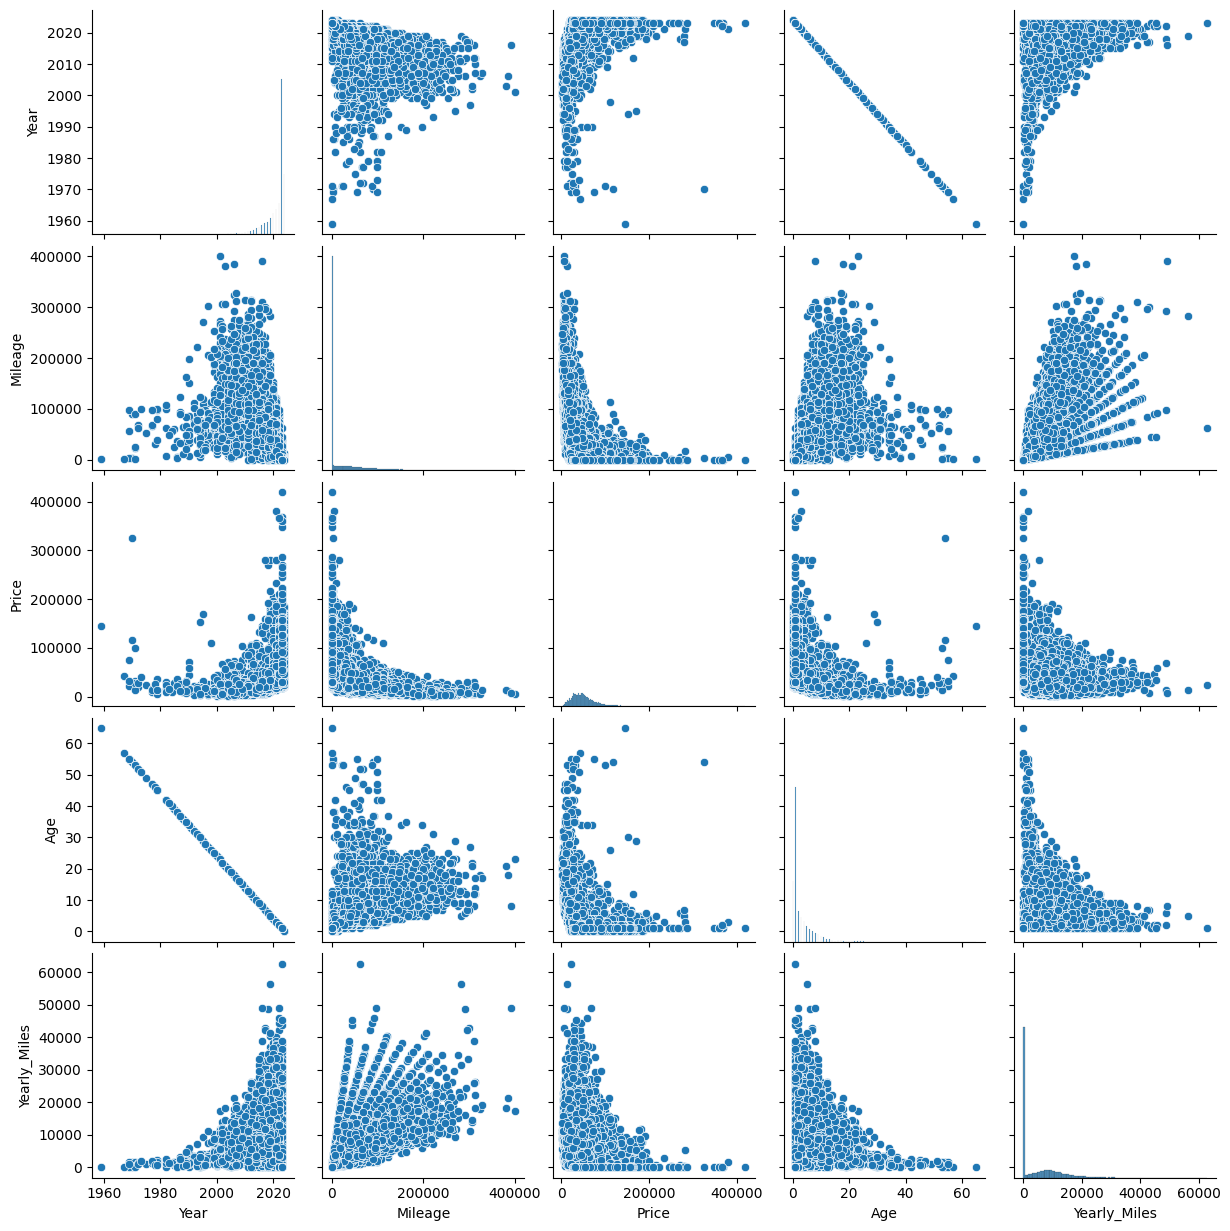

In [212]:
sns.pairplot(df_with_features)
plt.show()

### Breakdown by Car Manufacturer

In [186]:
brand_counts = df_with_features['Brand'].value_counts()
for brand, count in brand_counts.items():
    print(f"{brand}: {count} rows")


ford: 6255 rows
chevrolet: 4893 rows
toyota: 4598 rows
jeep: 3100 rows
gmc: 2517 rows
bmw: 2403 rows
mercedes: 2017 rows
honda: 1969 rows
lexus: 1769 rows
ram: 1719 rows
kia: 1671 rows
audi: 1478 rows
nissan: 1424 rows
dodge: 1167 rows
mazda: 1139 rows
cadillac: 1130 rows
hyundai: 1107 rows
volkswagen: 1018 rows


In [190]:
grouped_by_brand = df_with_features.groupby('Brand')
brand_datasets = {brand: group for brand, group in grouped_by_brand if len(group) > 1000}

brand_datasets['ford'].columns

Index(['Brand', 'Model', 'Year', 'Status', 'Mileage', 'Dealer', 'Price', 'Age',
       'PriceRange', 'Yearly_Miles'],
      dtype='object')

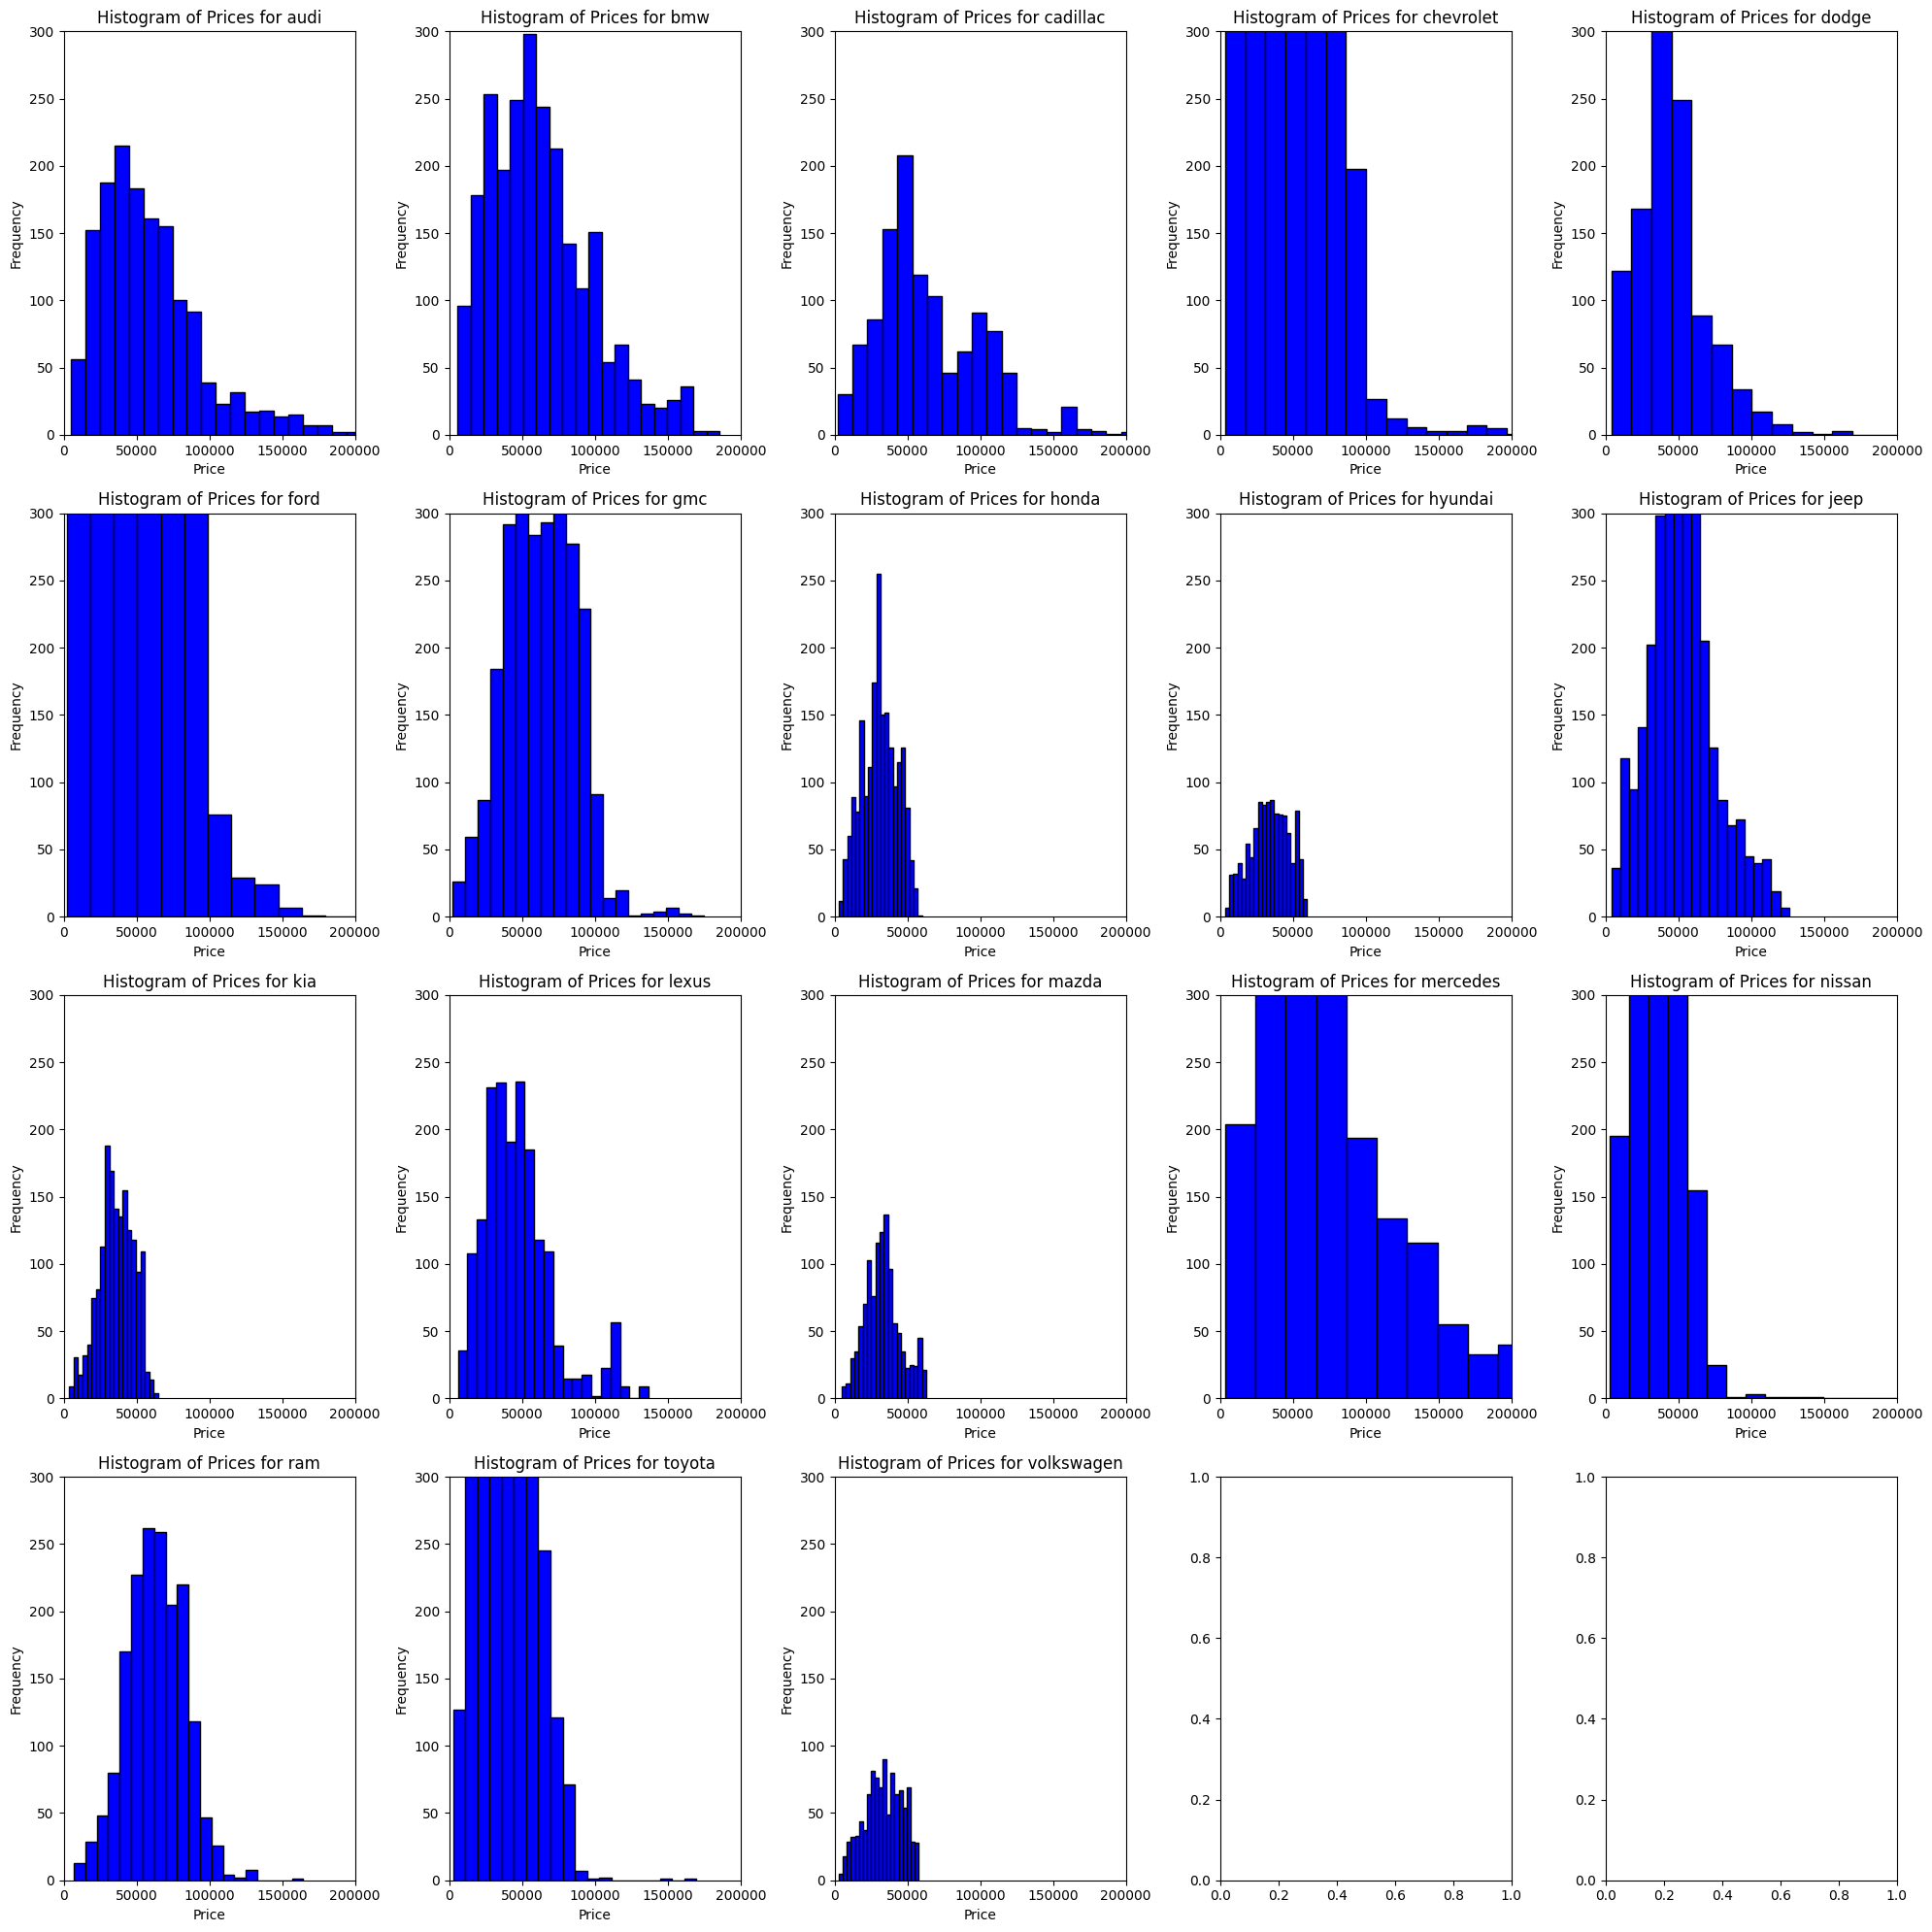

In [192]:
import matplotlib.pyplot as plt

# Assuming brand_datasets is a dictionary containing DataFrames for each brand
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
axs = axs.flatten()
c = 0

for brand, brand_df in brand_datasets.items():
    axs[c].hist(brand_df['Price'], bins=20, color='blue', edgecolor='black')
    
    axs[c].set_xlabel('Price')
    axs[c].set_ylabel('Frequency')
    axs[c].set_title(f'Histogram of Prices for {brand}')
    
    axs[c].set_xlim(0, 200000)
    axs[c].set_ylim(0, 300)
    c += 1
    

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


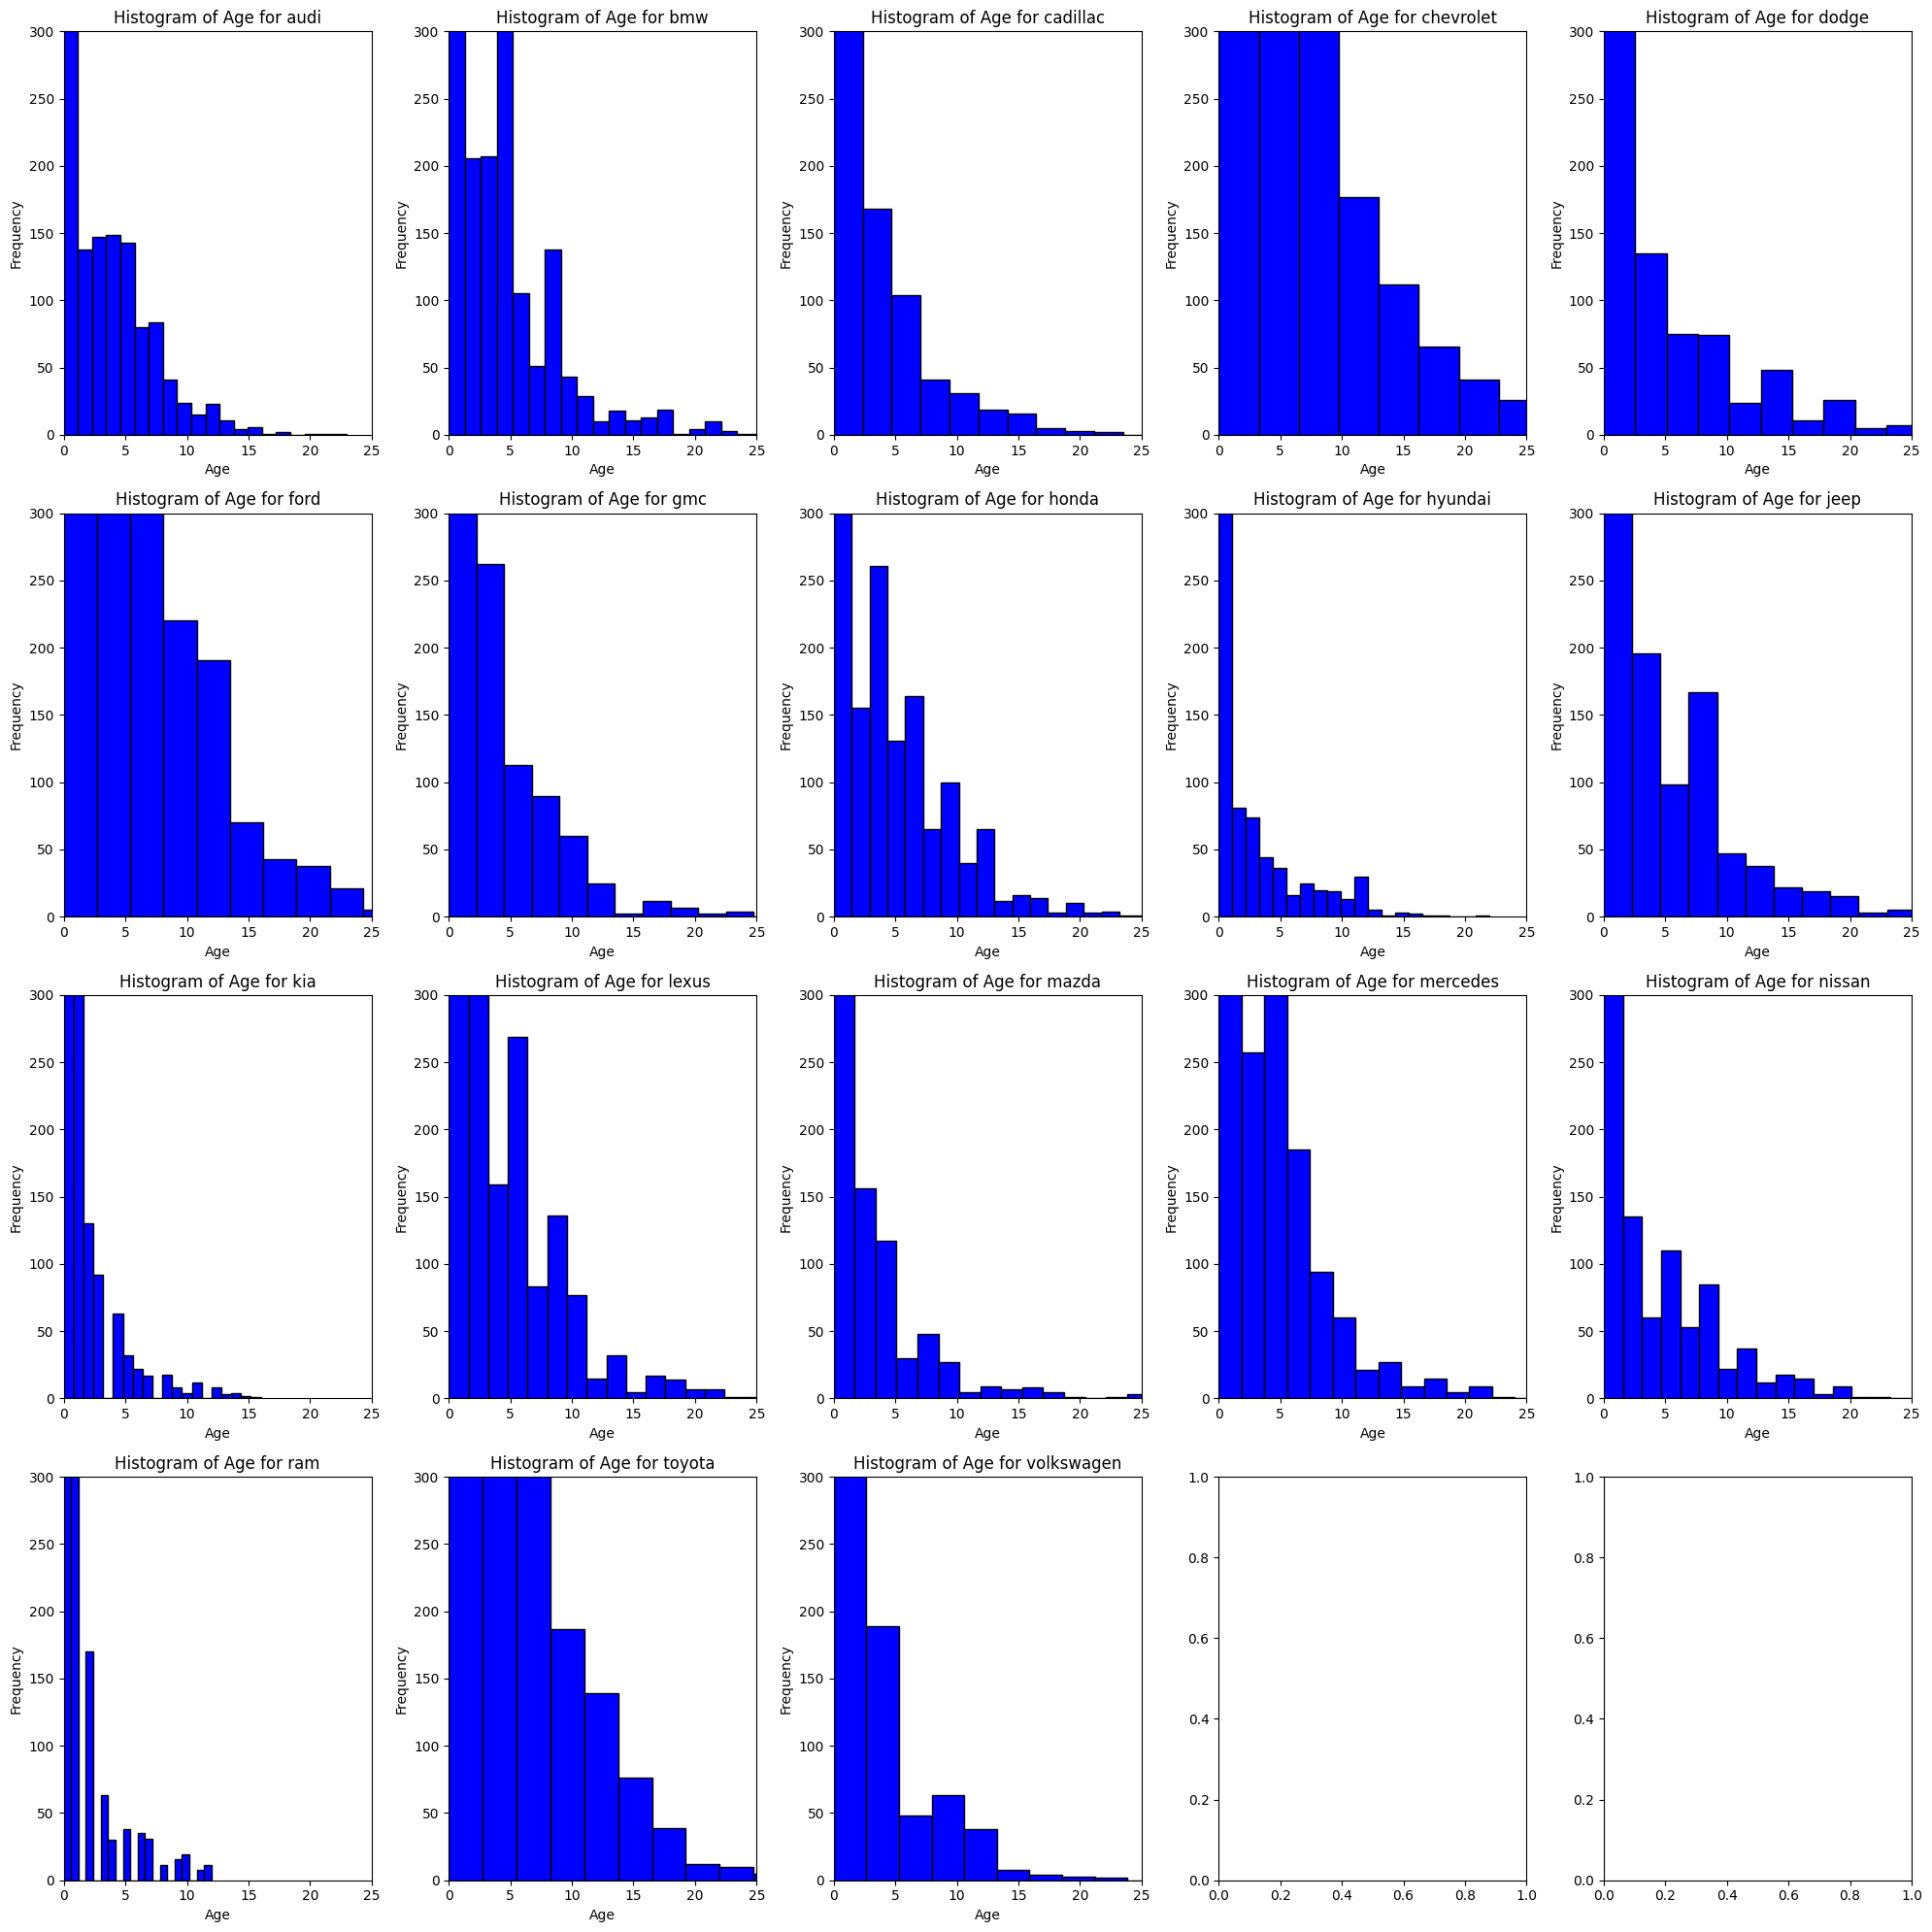

In [193]:
import matplotlib.pyplot as plt

# Assuming brand_datasets is a dictionary containing DataFrames for each brand
fig, axs = plt.subplots(4, 5, figsize=(20, 20))
axs = axs.flatten()
c = 0

for brand, brand_df in brand_datasets.items():
    axs[c].hist(brand_df['Age'], bins=20, color='blue', edgecolor='black')
    
    axs[c].set_xlabel('Age')
    axs[c].set_ylabel('Frequency')
    axs[c].set_title(f'Histogram of Age for {brand}')
    
    axs[c].set_xlim(0, 25)
    axs[c].set_ylim(0, 300)
    c += 1
    

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Feature Engineering

In [188]:
# Add feature to label each price range

# Label prices in 10k intervals
def priceToLabel(price):
    lower = int(price / 10000)
    return f'${lower*10000}-{lower*10000+9999}'
    
df_with_features['PriceRange'] = df_with_features['Price'].apply(priceToLabel)

for price in df_with_features['PriceRange'].unique():
    print(price, end=",\t")

print()
print(len(df_with_features['PriceRange'].unique()))

$20000-29999,	$40000-49999,	$50000-59999,	$30000-39999,	$60000-69999,	$70000-79999,	$90000-99999,	$80000-89999,	$100000-109999,	$10000-19999,	$130000-139999,	$0-9999,	$120000-129999,	$170000-179999,	$110000-119999,	$150000-159999,	$190000-199999,	$200000-209999,	$160000-169999,	$320000-329999,	$260000-269999,	$140000-149999,	$180000-189999,	$270000-279999,	$240000-249999,	$360000-369999,	$280000-289999,	$410000-419999,	$210000-219999,	$340000-349999,	$250000-259999,	$220000-229999,	$350000-359999,	$230000-239999,	$370000-379999,	
35


C:\Users\Boomin\AppData\Local\Temp\ipykernel_53924\986021576.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_features['PriceRange'] = df_with_features['Price'].apply(priceToLabel)


In [189]:
#average mileage per year
df_with_features['Yearly_Miles'] = round(df_with_features['Mileage'] / df_with_features['Age'], 2 )

C:\Users\Boomin\AppData\Local\Temp\ipykernel_53924\400965133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_features['Yearly_Miles'] = round(df_with_features['Mileage'] / df_with_features['Age'], 2 )


## Fitting Models

### Final Dataset Preparation

In [195]:
# One-hot encode certain columns
df_linreg = df_with_features.copy()
columns_to_encode = ['Brand', 'Model', 'Status']

encoder = OneHotEncoder()
onehot_encoded = encoder.fit_transform(df_with_features[columns_to_encode])
onehot_encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode))

df_linreg = pd.concat([df_linreg, onehot_encoded_df], axis=1)


In [196]:
# Normalize columns to be between 1 and 0
df_linreg['Age'] = (df_linreg['Age'] - df_linreg['Age'].min()) / (df_linreg['Age'].max() - df_linreg['Age'].min())
df_linreg['Mileage'] = (df_linreg['Mileage'] - df_linreg['Mileage'].min()) / (df_linreg['Mileage'].max() - df_linreg['Mileage'].min())
df_linreg['Yearly_Miles'] = (df_linreg['Yearly_Miles'] - df_linreg['Yearly_Miles'].min()) / (df_linreg['Yearly_Miles'].max() - df_linreg['Yearly_Miles'].min())

In [197]:
# Filter Outliers
df_linreg = df_linreg[df_linreg['Price'] <= 175000]
df_linreg = df_linreg[df_linreg['Age'] <= 15]
df_linreg = df_linreg[df_linreg['Age'] <= 200000]

In [198]:
# Final Data cleaning
df_linreg = df_linreg.drop(columns=['Brand', 'Model', 'Status', 'PriceRange', 'Dealer', 'Year'])

df_linreg.replace([np.inf, -np.inf], np.nan, inplace=True)
df_linreg = df_linreg.dropna()

In [199]:
df_linreg

,Mileage,Price,Age,Yearly_Miles,Brand_audi,Brand_bmw,Brand_cadillac,Brand_chevrolet,Brand_dodge,Brand_ford,...,Model_xterra,Model_xts,Model_yaris,Model_yukon,Model_z,Model_z sport,Model_z4,Status_certified,Status_new,Status_used
0,0.000000,28990.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.003874,58900.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.034703,34000.0,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.171096,56954.0,0.046154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,0.000000,61715.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41366,0.047648,34327.0,0.046154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41368,0.121510,55489.0,0.046154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41369,0.069908,41748.0,0.015385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41370,0.115860,48359.0,0.061538,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [200]:
X = df_linreg.drop('Price', axis=1)
y = df_linreg['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [204]:
model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [205]:
# Visualize differnece between truth and predictions
predictions_df = pd.DataFrame({'Actual_Labels': y_test, 'Predictions': y_pred}, index=X_test.index)
predictions_df['Difference'] = predictions_df['Actual_Labels'] - predictions_df['Predictions']
predictions_df['Hits'] = np.where(np.abs(predictions_df['Difference']) <= 5000, 1, 0)


print(round(predictions_df['Hits'].sum()/5742, 2))

0.21


In [206]:
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pcc, _ = pearsonr(y_true, y_pred)
    return mse, r2, pcc

print("Logistic Regression\tMSE\tR^2\tPCC")
print(" Test set: \t\t{:.3f} \t{:.3f} \t{:.3f}".format(*evaluate(y_test, y_pred)))


Logistic Regression	MSE	R^2	PCC
 Test set: 		439374010.010 	0.317 	0.563


### XGBoost Decision Tree

In [207]:
df_xgb = df_with_features.copy()

# Filter Outliers
df_xgb = df_xgb[df_xgb['Price'] <= 175000]
df_xgb = df_xgb[df_xgb['Age'] <= 15]
df_xgb = df_xgb[df_xgb['Age'] <= 200000]

df_xgb.replace([np.inf, -np.inf], np.nan, inplace=True)
df_xgb = df_xgb.dropna()


In [208]:
label_encoder = LabelEncoder()

# save og categorical variables 
X_Brand = df_xgb['Brand']
X_Model = df_xgb['Model']
X_Status = df_xgb['Status']
Y_PriceRange = df_xgb['PriceRange']

# label encode the categorical variables
df_xgb["Brand"] = label_encoder.fit_transform(df_xgb["Brand"])
df_xgb["Model"] = label_encoder.fit_transform(df_xgb["Model"])
df_xgb["Status"] = label_encoder.fit_transform(df_xgb["Status"])
y = label_encoder.fit_transform(Y_PriceRange)

X = df_xgb.drop(columns=['PriceRange','Dealer', 'Price', 'Year'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Brand,Model,Status,Mileage,Age,Yearly_Miles
31767,9,152,1,0.0,1,0.00
14140,5,200,1,0.0,1,0.00
19904,6,262,1,0.0,1,0.00
21795,3,263,2,60326.0,11,5484.18
6248,10,258,0,29704.0,2,14852.00
...,...,...,...,...,...,...
24659,3,80,2,69672.0,7,9953.14
8977,4,74,1,0.0,1,0.00
16292,0,242,1,0.0,1,0.00
1185,5,60,1,0.0,1,0.00


In [209]:
'''TAKES 10 MINUETS TO RUN'''

# param_grid = {
#     'n_estimators': [175, 225, 150],
#     'max_depth': [11, 13, 15],
#     'learning_rate': [0.15, 0.1, 0.8]
# }

# xgb_model = xgb.XGBClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3)

# grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)



'TAKES 10 MINUETS TO RUN'

In [210]:
xgb_model = xgb.XGBClassifier(
    n_estimators=150,  
    max_depth=9,  
    learning_rate=0.1, 
    random_state=42
)

xgb_fitted = xgb_model.fit(X_train, y_train)
y_pred = xgb_fitted.predict(X_test)
y_pred_proba = xgb_fitted.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Pred_proba:", accuracy)

Accuracy: 0.51253895236682
Pred_proba: 0.51253895236682


              precision    recall  f1-score   support

           0       0.72      0.65      0.68       141
           1       0.74      0.74      0.74       582
           2       0.30      0.43      0.36        75
           3       0.55      0.34      0.42        65
           4       0.28      0.19      0.23        26
           5       0.36      0.19      0.24        27
           6       0.25      0.14      0.18        14
           7       0.25      0.25      0.25        16
           8       0.58      0.35      0.44        20
           9       0.00      0.00      0.00         5
          10       0.63      0.68      0.65       972
          11       0.58      0.58      0.58      1163
          12       0.52      0.56      0.54      1240
          13       0.39      0.39      0.39       907
          14       0.36      0.37      0.36       628
          15       0.34      0.43      0.38       410
          16       0.34      0.16      0.22       291
          17       0.27    

C:\Users\Boomin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Boomin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Boomin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

<Figure size 3000x2400 with 0 Axes>

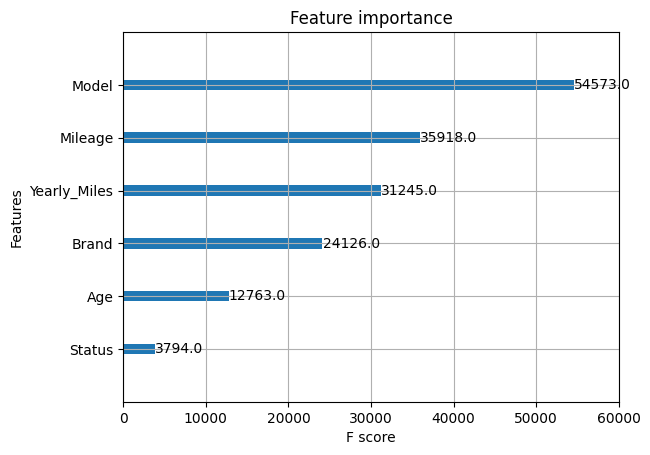

In [211]:
from xgboost import plot_importance

f = plt.figure(figsize=[30,24])
matplotlib.rcParams.update({'font.size': 10})
plot_importance(xgb_fitted, max_num_features=20)
print(classification_report(y_test,y_pred))

y_pred_proba = xgb_fitted.predict_proba(X_test)[:, 1]